In [ ]:
# Now this is the last corpus of data I worked with, and it was a relative success!
    # Basically, I was able to download and import all of the digitally copied out novels in the Eighteenth Century Collections Online Database
        # Yay!!!

# However, by the time I finished all of this, and then started running word2vec(a machine learning model that analyzes word relationships)
    # I realized this still wasn't enough data to use for models like that!
        # I hoped that 2500 texts would be enough, but unfortunately the model was still showing enough signs of specific texts being overrepresented that I decided to call it off
    # I was glad to have gone through the process, though unfortunately wasn't able to get the results/data I hoped for

In [56]:
import pandas as pd
import codecs
import numpy as np
import glob
import os
import csv
import xml.etree.ElementTree as ET
import re
import roman
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
from sklearn.manifold import MDS
# Importing everything - I did a lot of things!

In [4]:
# Here, I'm creating a function that goes through all the data and cleans it up to be analyzed, removed all errors, etc
def my_cleaner(s):
    cleaned = re.sub('<[^>]+>', '', s) # Removes stuff between <>
    cleaned = re.sub('\n', ' ', cleaned) # Replaces newline characters with space
    cleaned = re.sub('(\w+)?@\w+','',cleaned) # Removes whole word if it has an '@' (i.e. usernames)
    cleaned = re.sub('[^a-z\s\.\d\']+','',cleaned,flags=re.IGNORECASE) #Removes other non-alphabetical characters(EXCEPT PERIODS)
    cleaned = re.sub('(\s+)',' ',cleaned) # Remove multiple spaces
    cleaned = re.sub('(\s\.)', '.', cleaned) # Replaces space then period ' .' with period
    cleaned = re.sub('(\.\.)', '.', cleaned) # Fixes double periods
    cleaned_str=cleaned.lower()
    
    return cleaned_str

In [5]:
# This was a very neat function I created that I unfortunately never used, that would scan through the text of a novel,
    # find the publishing year, and render it as a date whether it was written as a number or in roman numerals(as was popular at the time)
    
    # I had hoped to pair this with the data to study trends over the course of the century, but there just weren't enough texts to support that kind of analysis
def year_identifier(t):
    print_loc = t.find("printed")
    
    tagline = t[print_loc: print_loc+150]
    
    if any(char.isdigit() for char in tagline):
        str_numbers = [str(i) for i in range(0,10)] # create a list of string numbers from 0 to 9

        list_int = []  # empty list to be filled with all integers found in string
        final_list = []
        temp = str()  # a temporay string needed to extract each integer

        for char in tagline:  # loop all the characters of the string
            if char in str_numbers:  # if the character is a number ...
                temp += char   # ...add the character to the temporary string
            else:   
                if temp:   # if the temporary string is not empty (i.e. integer previously found)
                    list_int.append(int(temp))   # add the integer found to the list...
                temp = ''   # ... and reset the temporary string

        if temp:  # this is for including the last integer found, in the case it's located right at the end of the string
            list_int.append(int(temp))
        
        for number in list_int:
            if 1700 <= number <= 1800:
                final_list.append(number)

        return max(final_list)
    else:
        word_list = tagline.split()
        
        for word in word_list:
            if word[:2] in ('mm', 'md'):
                word = word.upper()
                word = re.sub('(\.)+', '', word)
                n = roman.fromRoman(word)
                
                return n

In [6]:
meta_path = 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\'

In [8]:
# Here I'm getting a list of where every novel is on my computer!(I had to download them all)
filepaths = []

for root, dirs, files in os.walk(meta_path):
    for file in files:
        filepaths.append(os.path.join(root, file))
        
len(filepaths), print(filepaths)

['C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K000934.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K006151.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K019955.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K020978.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K021626.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K022415.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K023025.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K023176.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K027775.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K027776.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K029412.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K032308.000.xml', 'C:\\Users\\kayde\\Desktop\\ENGL 301\\ecco_XML\\xml-200510\\K03

(2473, None)

In [9]:
# Here I'm importing the texts into Python, and then turning them into manipulatable strings
texts = []
encoding = 'utf-8'

for file in filepaths:
    tree = ET.parse(file)
    root = tree.getroot()
    xmlstr = ET.tostring(root, encoding='utf8', method='xml')
    xmlSTRING = xmlstr.decode(encoding)
    texts.append(xmlSTRING)

In [14]:
# Now, using that function from earlier to clean the texts up!
cleaned_texts = []

for text in texts:
    clean_text = my_cleaner(text)
    cleaned_texts.append(clean_text)

In [16]:
text_file = open("\\Users\\kayde\\Desktop\\ENGL 490\\DATA_LESSON_5\\jockers_stopwords.txt", "r", encoding='utf8')
stop = text_file.read().split() 

# Here I'm removing stop words, common words and names (e.g. "the", "and", "sara") that get in the way of text analysis

def stopword_remover(w):
    clean_w = []
    split_w = w.split()
    for word in split_w:
        if word not in stop:
            clean_w.append(word)
    stopped_string = " ".join(clean_w)
    return stopped_string

In [17]:
stopped_texts = []
# Organizing the stopped texts!
for text in cleaned_texts:
    stop_text = stopword_remover(text)
    stopped_texts.append(stop_text)

In [18]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(stopped_texts)
tf_feature_names = tf_vectorizer.get_feature_names()
tf
# This is where it gets a bit complicated, basically, I'm analyzing every word in every text in comparison with every other word
    # then, generating a matrix(or graph with a lot of dimensions) that compares every word to every other word in every text

<2473x656043 sparse matrix of type '<class 'numpy.int64'>'
	with 8772551 stored elements in Compressed Sparse Row format>

In [19]:
lda = LatentDirichletAllocation(15, max_iter=50, # first parameter is # OF TOPICS, YOU DECIDE
                                learning_method='online', learning_offset=50.,random_state=0).fit(tf)
# Now I'm analyzing that complex matrix through machine learning to determine the most common "ideas" or topics that reoccur across all texts

In [20]:
lda_W = lda.transform(tf)
lda_H = lda.components_

In [21]:
def display_topics(H, W, feature_names, documents, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(H):
        ("Topic %d:" % (topic_idx))
        topics.append((("Topic %d:" % (topic_idx)), " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])))
        
    return topics
            
no_top_words = 20 

topics = display_topics(lda_H, lda_W, tf_feature_names, stopped_texts, no_top_words)
topics

# Now, let's see what the most common topics are! Some of these are quite interesting, e.g. topic 14 and painting, topic 5 and geology, topic 13 and numbers
    # However, this also clearly reveals the problem with so little data, novel-specific topics appear that are supposed to represent all of them!
        # For instance, as much as I love Tristram Shandy(Topic 11), there certainly shouldn't be a topic basically devoted to that one novel!
        
    # This is where I realized this wasn't likely going to work

[('Topic 0:',
  'sir thy mr thou heart dear thee mrs ll life lord friend give little father er you tis take hand'),
 ('Topic 1:',
  'duchesne lafourbe rosalie velazquez mengs alciris murillo olissus jennetta marinette jordano picard luca pourtraits castillo gradating trussmaker antoine alfaro corrado'),
 ('Topic 2:',
  'yn harlow mush custom moody abs doc jesus miracles miracle belv faulk eclipse tang peg caust acres crumpy ei alibi'),
 ('Topic 3:',
  'time men mr people having power little present god general country life it place person nature manner give england world'),
 ('Topic 4:',
  'army enemy troops emperor sultan battle empire city camp war march sent marched having forces death victory throne shaw river'),
 ('Topic 5:',
  'fossil shells polished ore italy murchoe large petrifactions marble ditto corals various echini dooneflaith crystallised copper curious minerals spar iron'),
 ('Topic 6:',
  'genuine constable amerced rotulis campbel bowar doil not elne archbald steuart wi

In [25]:
cleaned_texts

350401

In [26]:
# At this point I just wanted to try something else, so I ran word2vec, 
    # which is a machine learning algorithm that studies the relationships between words across all the novels, and then can represnt those connection on a graph!

    # It's pretty cool, but really needs more data
import nltk
nltk.download('punkt')
sentences = [sentence for novel in cleaned_texts for sentence in nltk.sent_tokenize(novel)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kayde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
def fast_tokenize(text):
    
    # Get a list of punctuation marks
    from string import punctuation
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in text if char not in punctuation])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

In [28]:
words_by_sentence = [fast_tokenize(sentence.lower()) for sentence in sentences]

In [29]:
pip install gensim --user

Note: you may need to restart the kernel to use updated packages.


In [30]:

import gensim
model = gensim.models.Word2Vec(words_by_sentence, window=5, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)
# Everything up to here is just setting up the data, here's where I run the actual model!

In [91]:
model.wv.most_similar(positive=['female'], topn=20)
# Now I can doing analysis of the word relationships, for instance, what are the most common words related to "female"?

[('feminine', 0.6888397336006165),
 ('male', 0.663273811340332),
 ('females', 0.6564817428588867),
 ('womans', 0.5600438714027405),
 ('males', 0.5563136339187622),
 ('masculine', 0.5540750622749329),
 ('coquette', 0.5350486636161804),
 ('coquetry', 0.5314685106277466),
 ('women', 0.5215474367141724),
 ('sex', 0.5186329483985901),
 ('beauty', 0.5072929859161377),
 ('circassian', 0.4994000196456909),
 ('parent', 0.49210861325263977),
 ('mulatto', 0.48605266213417053),
 ('softness', 0.4845643639564514),
 ('eunuchs', 0.48432520031929016),
 ('chaste', 0.4797709286212921),
 ('infantine', 0.4788152277469635),
 ('sensitive', 0.4781121611595154),
 ('harlot', 0.4714967906475067)]

In [88]:
god_terms = model.wv.most_similar(positive=['love'], topn=20)
god_terms = [word for word, score in god_terms]

# MAN
man_scores = []
woman_scores = []

for word in god_terms:
    score = model.wv.similarity(word, 'male')
    man_scores.append(score)
    
for word in god_terms:
    score = model.wv.similarity(word, 'female')
    woman_scores.append(score)
    
len(man_scores), len(woman_scores)

(20, 20)

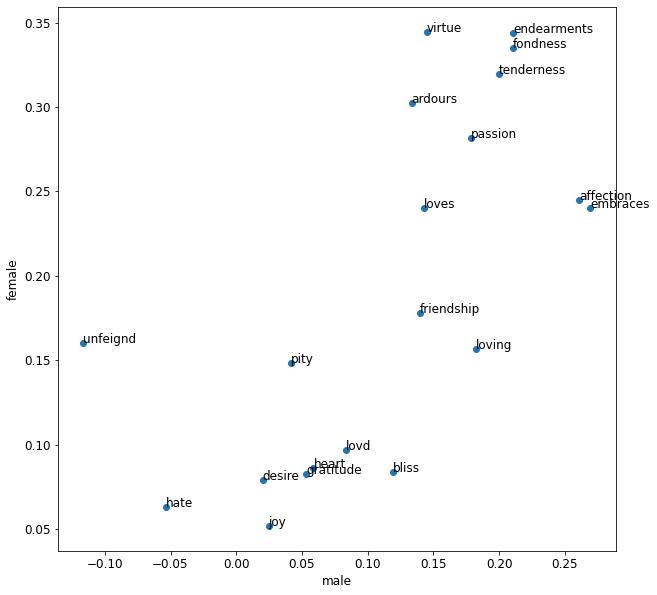

In [89]:
# Or, how do the words associated with love relate to male/female? This is represented on the graph below!

plt.rcParams.update({'font.size': 12})
_, ax = plt.subplots(figsize=(10, 10))
ax.scatter(man_scores, woman_scores)
plt.xlabel ('male')
plt.ylabel ('female')

for i, txt in enumerate(god_terms):
    ax.annotate(txt, (man_scores[i], woman_scores[i]))